# Predicting Wheat Futures with Overhead Aerial Imagery

This notebook serves as an introduction to segmented timeseries analysis by means of predicting Red Hard Wheat futures utilizing overhead aerial imagery. Through this tutorial you will use Keras's (Tensorflow) functional API to implement transfer learning and combine that with timeseries data. 

The following step are performed:
1. Upload
2. Process Data and Visualize Data
3. Implement a Model
4. Analyze Model Results
5. Next Steps and Questions

## Overview
The goal is to see if aerial imagery can provide additional information toward predicting market returns. 
This problem will phrased as a binary classification problem. We want to predict if the market will be above or below the currently trading price at sometime in the future. Then we will plot our predictions out-of-sample to see how we would do if we were to trade this.

Please note that this example is relatively contrived. We have a small amount of data, and therefore overfitting will be a major problem. In the validation set loss is not going down when the training set goes to nearly perfect. In practice you will have much more data, and this will not be as large of a problem. When you do have a larger dataset, you will need more powerful compute resources to iterate and train your model. In this tutorial, if you are using Colab, you have the option to access a GPU accelerated runtime.

**Thesis:**
    
    Crop health likely influences the spot price of a tradeable good

**Execution:**
    
    Using aerial imagery, learn the features that may indicate market performance. A simple ML model may help here. 

In [1]:
# General Imports
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import pandas as pd
import datetime
import numpy as np
import zipfile
# Model specific imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Softmax
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.layers import Concatenate, Average
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt
# If running locally on a Mac running High Sierra or higher
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Set seeds for reproducability.
# from numpy.random import seed
# seed(0)
# from tensorflow import set_random_seed
# set_random_seed(0)

In [2]:
def fuzzy_search(input_df, search_date, days, search_col):
    """ Finds the percent change and the direction for a given input

    Args:
        input_df: dataframe to search
        search_date: date to look
        days: days to search (can be positive or negative)
        search_col: column to search through

    Returns:
        pct_change: percentage change
        direction: 1, if positive, 0 if negative
    """
    search_date_after = search_date + datetime.timedelta(days=days)
    if days > 0:
        start = input_df.truncate(after=search_date).iloc[-1][search_col]
        end = input_df.truncate(after=search_date_after).iloc[-1][search_col]
    else:  # days < 0
        search_date_after = search_date + datetime.timedelta(days=days)
        start = input_df.truncate(after=search_date_after).iloc[-1][search_col]
        end = input_df.truncate(after=search_date).iloc[-1][search_col]

    pct_change = (end - start) / start
    direction = 1 if end > start else 0

    return pct_change, direction

def extract_from_zipfile(input_filepath, writepath):
    """ Unzips a zipfile. Note: do not pass in the .zip extension.
    
    Args:
        input_filepath: filepath without zip to extract
        writepath: path to extract data to
    
    Returns:
        bool: True if successful, else False
    """
    try:
        zip_ref = zipfile.ZipFile(input_filepath + ".zip", 'r')
        zip_ref.extractall(writepath)
        zip_ref.close()
        return True
    except:
        return False

## 1. Upload Data
If you are working within a Colab environment you will need to upload them using the command below. If you are working on your desktop you can skip the below step and make sure you reference the files in the workbook correctly. After running you will need to upload two files:
 * data.zip - images scraped from Google Earth
 * futures_data.zip - Back-adjusted wheat futures data
 
Simply click on the Choose Files and you will be able to upload your files.

In [3]:
#from google.colab import files
#uploaded = files.upload()

Extract our data to work with locally. The data is stored in two zipfiles:
 * data.zip - the images
 * futures_data.zip - the 

In [4]:
path = "."
img_data_dir = "data"
futures_data_dir = "futures_data"
assert extract_from_zipfile(img_data_dir, path)
assert extract_from_zipfile(futures_data_dir, path)

Get a dataframe and sort it by date. 

In [5]:
only_files = [f for f in os.listdir(img_data_dir) if os.path.isfile(os.path.join(img_data_dir, f))]
ids = list(map(str, range(len(only_files))))
df = pd.DataFrame([ids, only_files]).transpose()
df.columns = ["id", "name"]
df["Date"] = pd.to_datetime(df["name"].str.split("_").apply(lambda x: x[0]))
df.sort_values("Date", inplace=True)

Lets take a look at this dataframe. Below we can see that we have 3 columns; `id, name, Date`. From the `name` column we can extract a `Date` and identify where the picture was taken. This dataset has images going back from 1996!

In [6]:
df.head()

,id,name,Date
7,7,1996-03-25_greenwood-county.jpg,1996-03-25
0,0,1996-07-13_colfax-wa.jpg,1996-07-13
18,18,2002-02-19_greenwood-county.jpg,2002-02-19
17,17,2003-06-25_colfax-wa.jpg,2003-06-25
25,25,2003-08-23_greenwood-county.jpg,2003-08-23


## 2. Process and Visualize Data
Here we will process and visualize our data. It is paramount to get a good understanding of the data before building a model. First, we will investigate the overhead aerial imagery. Next, we examine the futures data. 

data/2014-08-05_colfax-wa.jpg


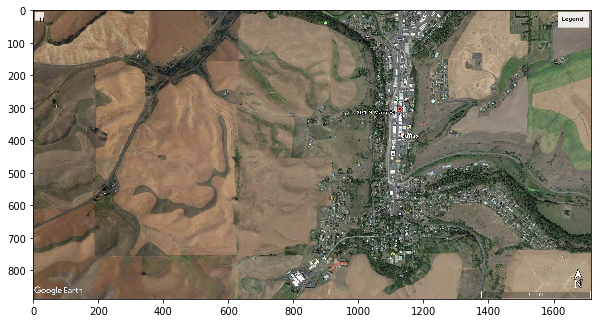

In [7]:
file_name = os.path.join(img_data_dir, df.iloc[-5]["name"])
print(file_name)
overhead_image = plt.imread(file_name)
plt.figure(figsize=(10, 8))
plt.imshow(overhead_image)
plt.show()

Here we have an image pulled from Google Earth on 2015-06-29 around 6 PM. This satellite image shows the landscape of part of the city and part of the farms around the surronding area. Our goal is to use this imagery over time to predict the future price of wheat. Play around yourself to look at different images. Next we will read in the images and resize them to be able to be fed into a machine learning model.

In [8]:
# Read in the images one-by-one
img_arrs = []
for i in range(len(only_files)):
    img_arr = img_to_array(load_img(os.path.join(img_data_dir, only_files[i]), target_size=(64,64))) / 255
    img_arrs.append(img_arr)
img_arrs = np.array(img_arrs)

Notice that we resized our input. We scaled down our images, thus causing us to lose information. Play with the different input parameters to investigate. Note that the pixel values are divided by 255 to normalize the inputs between 0-1. Machine learning models tend to converge better when values are normalized.

Now lets investigate the wheat futures data. The historical data shown are **Wheat Futures, Continuous Contract #1.** They are non-adjusted prices based on spot-month continuous contract calculations. The raw data comes from CME. In practice you would back-adjust the data, but for simplicity, this will be sufficient. [Here](http://www.nuclearphynance.com/User%20Files/7228/cntcontr.pdf) is an example comparing the different kinds of adjustments. There is no one **best** way to adjust data, each kind of adjustment has a different purpose.

In [9]:
# Load up a pandas dataframe of the futures data
fut_data = pd.read_csv("futures_data/CHRIS-CME_W1.csv", sep=",")
fut_data["Date"] = pd.to_datetime(fut_data["Date"])
fut_data.set_index("Date", inplace=True)
fut_data.sort_index(inplace=True)

Pandas was originally built and started by [Wes McKinney](http://wesmckinney.com/) at AQR to help quickly analyze timeseries data. 
Let's inspect the daily data. Remember there are some major simplifying assumptions made to make this tutorial. 

In [10]:
fut_data.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1959-07-01,195.7,196.7,195.7,196.4,NaN,196.4,5828.0,25273.0
1959-07-02,196.3,197.4,196.3,197.1,NaN,197.1,4780.0,26524.0
1959-07-06,196.6,197.6,196.6,197.0,NaN,197.0,6591.0,27452.0
1959-07-07,197.3,197.5,196.7,197.1,NaN,197.1,5604.0,28749.0
1959-07-08,197.2,197.4,196.3,196.4,NaN,196.4,4538.0,30527.0


Text(0, 0.5, 'Price')

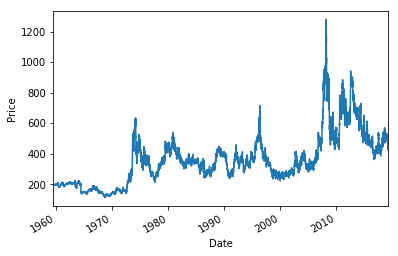

In [11]:
fut_data["Last"].plot()
plt.ylabel("Price")

Here we can see the continuous price of wheat going back until 1959! Look deeper into different parts of the data and get an intuition for any patterns that may emerge. 

Now that we have looked at the data, lets preform some pre-processing to the data so it can be more easily parsed. First lets compute the direction and percentage return before and after a given date corresponding to the dates in the aerial imagery.

In [12]:
# Compute the return after some amount of days
n_days = [-100, -60, -30, -14, -7, -1, 1, 7, 14, 30, 60, 180]
for duration in n_days:
    col_name_pct = "pct_after_" + str(abs(duration)) if duration>0 else "pct_before_" + str(abs(duration))
    col_name_direction = "direction_after_" + str(abs(duration)) if duration > 0 else "direction_before_" + str(abs(duration))
    col_pct = []
    col_direction = []
    for index, row in df.iterrows():
        percent_change, direction = fuzzy_search(fut_data, row.Date.date(), duration, search_col="Last")
        col_pct.append(percent_change)
        col_direction.append(direction)

    df[col_name_pct] = col_pct
    df[col_name_direction] = col_direction

Inspect this data, specfically looking for the change before and after an image date. Here in the direction columns 0 indicates a negative movement, and 1 indicates a positive movement. The percentage is a decimal form representation of the change. We will use these directional movements to help predict the future prices. Remember, our goal is to forecast the future **direction** from historical data.

In [13]:
df.head()

,id,name,Date,pct_before_100,direction_before_100,pct_before_60,direction_before_60,pct_before_30,direction_before_30,pct_before_14,...,pct_after_7,direction_after_7,pct_after_14,direction_after_14,pct_after_30,direction_after_30,pct_after_60,direction_after_60,pct_after_180,direction_after_180
7,7,1996-03-25_greenwood-county.jpg,1996-03-25,-0.031096,0,0.000000,0,-0.023869,0,-0.049395,...,0.042282,1,0.070301,1,0.378502,1,0.143148,1,-0.142129,0
0,0,1996-07-13_colfax-wa.jpg,1996-07-13,-0.042584,0,-0.251123,0,-0.008915,0,0.045455,...,-0.061469,0,-0.131434,0,-0.051474,0,-0.112444,0,-0.221889,0
18,18,2002-02-19_greenwood-county.jpg,2002-02-19,-0.028846,0,-0.038095,0,-0.067953,0,-0.018551,...,-0.007201,0,-0.012601,0,0.015302,1,-0.038704,0,0.252025,1
17,17,2003-06-25_colfax-wa.jpg,2003-06-25,0.028181,1,0.029060,1,-0.067390,0,-0.089259,...,0.018272,1,0.029900,1,0.137874,1,0.205150,1,0.280731,1
25,25,2003-08-23_greenwood-county.jpg,2003-08-23,0.070849,1,0.200165,1,0.056041,1,0.014685,...,0.013094,1,-0.048932,0,-0.047553,0,-0.022743,0,0.027567,1


## 3.  Implement a model
Now that we have built our data, lets build a Keras model. Keras is an open-source neural-network library written in Python. Here we use tf.keras and not the general framework that supports running ontop of other languages. It is user friendly and therefore will let us define a model architecture with ease. Here we will use the the [functional API](https://keras.io/getting-started/functional-api-guide/). This will allow us to quickly define a model architecture without much overhead work. 

In practice we should take a pre-trained model like, [MobileNet](https://arxiv.org/abs/1704.04861), which is trained on the [imagenet](http://www.image-net.org/) dataset. You would then freeze all but the last layers, and then combine with the timeseries input using the functional API. However, given that we have a very small dataset and need to run quickly (for demo purposes), we will instead *mock* the first few layers by implementing a Conv2D, Pooling, and a Dropout. 

For those who want to spend some time and incorporate MobileNet can be found here
```
base_model = MobileNet(weights='imagenet',include_top=False) #mobilenet and discards the last 1000 neuron layer.
# You can set the trainable layers
for layer in base_model.layers:
    layer.trainable=False # Sets all of the layers to be false, maybe you want to set some to be true?
    
# It is left as an exercise to the reader to implement this and figure out the inputs and outputs
```


In [14]:
# Build our model
# Note the input shape must be the same size as the images being fed in, notice the 3 inputs for RGB.
picture_input = Input(shape=(64,64,3), dtype="float32", name="picture_input")
ts_input =      Input(shape=(2,), dtype="float32", name="ts_input")
dense_ts =      Dense(10)(ts_input)
hidden_1 =      Conv2D(32, (3,3), activation="relu")(picture_input)
hidden_2 =      MaxPooling2D(pool_size=(2,2))(hidden_1)
hidden_3 =      Dropout(0.25)(hidden_2)
flatten_layer = Flatten()(hidden_3)
dense_conv_f =  Dense(10)(flatten_layer)
activation_0 =  Activation("relu")(dense_conv_f)
merged =        Concatenate()([activation_0, dense_ts])
activation_1 =  Activation("relu")(merged)
dense =         Dense(1)(activation_1)
# softmax =       Softmax()(dense) # for those who understand softmax, this can be used 
model =         Model(inputs=[picture_input, ts_input], outputs=dense)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [15]:
# Define our optimizer
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
# Compile our model
model.compile(loss='mean_squared_error', metrics=['accuracy', 'mae'], optimizer=sgd)

Instructions for updating:
Use tf.cast instead.


In [16]:
# Fit our model
validation_split_size = 0.4
prediction_column = "direction_after_30"
hist = model.fit([img_arrs, df[["direction_before_14", "direction_before_30"]].values], np.array(df[prediction_column]), epochs=50, verbose=1, validation_split=validation_split_size)


Train on 16 samples, validate on 11 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
16/16 [==============================] - 1s 56ms/sample - loss: 1.1550 - acc: 0.4375 - mean_absolute_error: 1.0113 - val_loss: 9.7789 - val_acc: 0.2727 - val_mean_absolute_error: 3.0199
Epoch 2/50
16/16 [==============================] - 0s 5ms/sample - loss: 8.3568 - acc: 0.5625 - mean_absolute_error: 2.8257 - val_loss: 0.6358 - val_acc: 0.7273 - val_mean_absolute_error: 0.6705
Epoch 3/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.8931 - acc: 0.4375 - mean_absolute_error: 0.8881 - val_loss: 0.6338 - val_acc: 0.7273 - val_mean_absolute_error: 0.6682
Epoch 4/50
16/16 [==============================] - 0s 7ms/sample - loss: 0.8843 - acc: 0.4375 - mean_absolute_error: 0.8840 - val_loss: 0.5840 - val_acc: 0.7273 - val_mean_absolute_error: 0.6313
Epoch 5/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.8251 - acc: 0.4375 - mean_absolute_error: 0.848

16/16 [==============================] - 0s 5ms/sample - loss: 0.0958 - acc: 0.8750 - mean_absolute_error: 0.2536 - val_loss: 0.2311 - val_acc: 0.6364 - val_mean_absolute_error: 0.3767
Epoch 42/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.0942 - acc: 0.8750 - mean_absolute_error: 0.2477 - val_loss: 0.2343 - val_acc: 0.6364 - val_mean_absolute_error: 0.3753
Epoch 43/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.0927 - acc: 0.8750 - mean_absolute_error: 0.2414 - val_loss: 0.2377 - val_acc: 0.6364 - val_mean_absolute_error: 0.3735
Epoch 44/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.0914 - acc: 0.8750 - mean_absolute_error: 0.2348 - val_loss: 0.2411 - val_acc: 0.6364 - val_mean_absolute_error: 0.3716
Epoch 45/50
16/16 [==============================] - 0s 5ms/sample - loss: 0.0903 - acc: 0.8750 - mean_absolute_error: 0.2283 - val_loss: 0.2445 - val_acc: 0.6364 - val_mean_absolute_error: 0.3696
Epoch 46/50
16/16 [========

Now that we have built and trained our model. Take a look at what the model looks like. We have 2 inputs, specified as InputLayer's. They are then combined and used to predict the output.

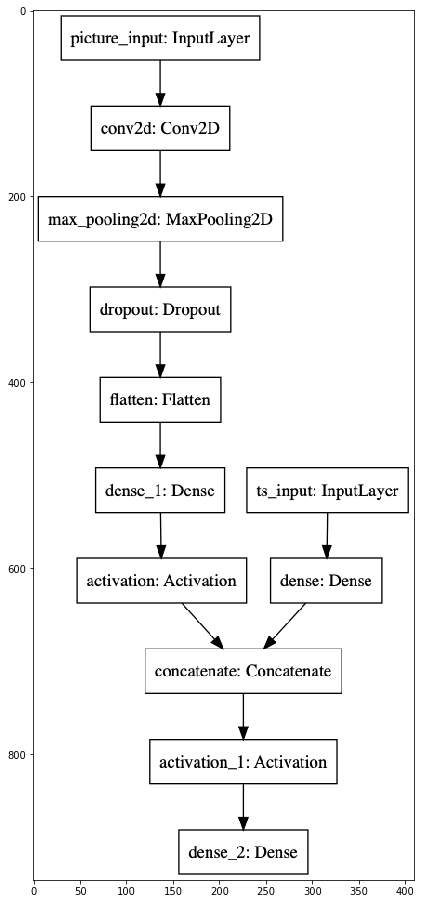

In [17]:
# Plot and view the model we have built
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')
plt.figure(figsize=(12,16))
an_image = plt.imread("model.png")
plt.imshow(an_image)
plt.show()

## 4. Analyze Model Results
Now that we have out data fitted, let's look at the performance of the model. Due to the small size of the data we will only be looking at our validation set performance. In practice you would have a holdout set and look at that performance (because you can bias yourself by fitting to the validation set). 

Since our dataset is so small, we do not have the luxury to do this. In the future you would make sure that your validation set performs about the same as the in-sample to ensure that you are building generalizable models, models that are actually learning something, and not just "memorizing" the input data. 

As a note, your validation set and your holdout set should come from the same distribution. The training set, need not come from the same distribution as you can learn from supplemental data.

Now we can predict with our model and see the performance. 

In [18]:
val_set_index = round(len(df)* validation_split_size) * -1
preds = model.predict([img_arrs[val_set_index:], df[["direction_before_14", "direction_before_30"]].values[val_set_index:]])
preds = list(map(lambda x: x[0], preds))
actuals_direction = df[prediction_column].values[val_set_index:]
actuals_performance = df["pct_after_30"].values[val_set_index:]
initial_trade_dates = df["Date"].values[val_set_index:]
days_shift = int(prediction_column.split("_")[-1])
end_trade_dates = list(map(lambda x: pd.to_datetime(x).date()+datetime.timedelta(days=days_shift), initial_trade_dates))

In [19]:
res_df = pd.DataFrame([list(preds), list(actuals_direction), list(actuals_performance), list(initial_trade_dates), list(end_trade_dates)]).transpose()


Now look at our predictions and the actual direction and performance. Remember we are trying to predict the actual direction and not the performance. Notice how we have values that can be above 1 and below 0. However, the values should be somewhere around 0.5. In practice you would use a binary classification problem and use a softmax for predictions. However, this is being exposed to show you the ouputs.

In [20]:
res_df.columns = ["predictions", "acutal_direction", "actual_performance", "start_date", "end_date"]
res_df.head(11)

,predictions,acutal_direction,actual_performance,start_date,end_date
0,0.68454,0,-0.172603,2011-09-04T00:00:00.000000000,2011-10-04
1,-0.0136979,0,-0.0373428,2011-11-03T00:00:00.000000000,2011-12-03
2,0.944801,0,-0.0166284,2012-09-06T00:00:00.000000000,2012-10-06
3,0.944828,1,0.00418092,2013-07-04T00:00:00.000000000,2013-08-03
4,0.944801,0,-0.0287026,2013-07-24T00:00:00.000000000,2013-08-23
5,0.461257,1,0.0828751,2013-09-03T00:00:00.000000000,2013-10-03
6,0.461257,0,-0.0488688,2014-08-05T00:00:00.000000000,2014-09-04
7,-0.0136979,0,-0.139323,2015-06-29T00:00:00.000000000,2015-07-29
8,-0.0136979,0,-0.193168,2015-06-30T00:00:00.000000000,2015-07-30
9,0.68454,1,0.0287462,2016-12-30T00:00:00.000000000,2017-01-29


Now let's do a backtest. We can have overlap and multiple trade times. We will assume that we have multiple cash and overlap is relatively small. In practice this would be done in a vectorized manner, but done so to demonstrate how an event driven backtest works. 

Consider the threshold, try different values and see how it changes the performance. 

In [21]:
# Do a backtest, note we can have overlap and trade multiple times, this assumes we have infinite cash
# In practice we would do this in a vectorized manner, however this is done with an explicit for-loop to demonstrate
# How a backtest is done
# Consider adjustments of different thresholds, i.e. predict when we are more confident. 
# Note for simplicity we have not given a "true classification with probabilities", this would be done by putting a softmax at the end
long_threshold = 0.5
short_threshold = 0.5
initial_cash = 100
trade_dates = []
pnl = []
for idx, row in res_df.iterrows():
    if row.predictions >= long_threshold:
        # trade long
        initial_cash = initial_cash + initial_cash*row.actual_performance
        pnl.append(initial_cash)
        trade_dates.append(row.end_date)
    if row.predictions < short_threshold:
        # trade short
        initial_cash = initial_cash + initial_cash*row.actual_performance*-1
        pnl.append(initial_cash)
        trade_dates.append(row.end_date)
pnl_df = pd.DataFrame([pnl, trade_dates]).transpose()

Now lets plot an "equity curve" and see how we would have done out-of-sample!

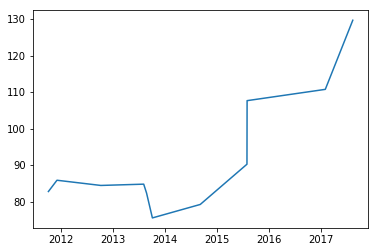

In [22]:
plt.plot(trade_dates, pnl)

Congrats! You have implemented your own neural network to predict futures prices!

## 5. Reader Questions and Next Steps
1. Why does running the notebook multiple times show randomness?
2. Implement this by adding in MobileNet? How do you connect the layers?
    a. What happens when we freeze more layers? Speed? Overfit
3. Try different hyperparameters and see the resulting performance?
4. Add in more data!
5. Try on your own dataset!
6. Look deeper at model generalizability, what does it mean when training loss is going down, but validation loss stays the same? 
7. Why is it important to have a holdout set? 
8. What other data inputs could be useful here?
9. How would you improve this model?
10. What are some biases in the model?

> Contributed by Avi Thaker